# CAO POINTS ANALYSIS
### AUTHOR: ANTE DUJIC
<hr style="border:2px solid black"> </hr>

## INTRODUCTION
<hr style="border:2px solid gray"> </hr>

This notebook gives an overview of how to load CAO points information from the CAO website into a pandas data frame and the comparison of CAO points in 2019, 2020, and 2021.

[<center><img src="http://www.cao.ie/images/cao.png" width="100"/></center> ](http://www.cao.ie/index.php)

***
### CONTENTS

- [WHAT IS CAO](#CAO)
- [LEVEL 8 - ROUND 1 and ROUND 2](#R1R2)
    - [THE ORIGINAL DATA STRUCTURE]()
    - [SCRAPPING AND CLEANING THE DATA]()
    - [CLEANED DATA]()
- [LEVEL 8 - EOS and MID]()
    - [THE ORIGINAL DATA STRUCTURE]()
    - [SCRAPPING AND CLEANING THE DATA]()
    - [CLEANED DATA]()
2. [CONCATENATING THE DATA](#CONCATENATE)

## WHAT IS CAO? <a id='CAO'></a>
<hr style="border:2px solid gray"> </hr>

The purpose of the Central Applications Office (CAO) is to process centrally applications for undergraduate courses in Irish Higher Education Institutions (HEIs), and to deal with them in an efficient and fair manner. [1]

Students applying for admission to third level education courses in Ireland apply to the CAO rather than to individual educational institutions such as colleges and universities. The CAO then offers places to students who meet the minimum requirements for a course for which they have applied. If for a particular course there are more qualified applicants than available places, the CAO makes offers to those applicants with the highest score in the CAO points system. If students do not accepts offers, or later decline them because they receive an offer for another course, the CAO makes further offers until all of the places have been filled or until the offer season closes. [2]

In [1]:
# HTTP request
import requests as rq

# Regular expressions
import re

# Dates and time
import datetime as dt

# Data frames
import pandas as pd

# For downloading
import urllib.request as urlrq

# PDF
import camelot

# To use .unescape
import html

# Arrays
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

<br>
Current data and time are used for the filenames that will get created to save the original data and the cleaned data. I've used the date and time for easier access and organization of the data, but also to avoid the overwriting of the data files.

In [2]:
# Current date and time
now = dt.datetime.now()
# Format as a string
nowstr = (now.strftime("%Y%m%d_%H%M%S"))

## LEVEL 8 - ROUND 1 and ROUND 2
<hr style="border:2px solid gray"> </hr>

The data for Round 1 and Round 2 for the three given years (2019., 2020., 2021.) has been pulled from the CAO website. As mentioned in the README, CAO practice is to first upload the data with only Round 1 and Round 2 points and then overwrite that data with EOS and MID points after the academic year starts. To obtain the Round 1 and Round 2 data for the 2019. and 2020. I have used [The Internet Archive](https://web.archive.org/). This didn't only allow me access to the archived version of the website but also gave me the same format and the structure of the data for all the years.

### THE ORIGINAL DATA STRUCTURE
***

Original data: <br>
2019: https://web.archive.org/web/20191019135815/http://www2.cao.ie:80/points/l8.php <br>
2020: https://web.archive.org/web/20201108133105/http://www2.cao.ie/points/l8.php <br>
2021: http://www2.cao.ie/points/l8.php

The data for Round 1 and Round 2 points on the CAO website has the following structure:
- Title
- Information on how to read the data
- List of colleges
- Title
- Points
    - Course code
    - Course title
    - Round 1 points
    - Round 2 points

The data of interest is contained under the *Points* section of the website. It is explained below how the data was scrapped, cleaned and saved for the later analysis.

### SCRAPPING AND CLEANING THE DATA
***

<br>
To loop through the years and run multiple lines of code for each year in one go, I've created the dictionary below.

In [3]:
# Defining a dictionary
years_dict = {
    "2019": [("data/cao2019" +  nowstr), "https://web.archive.org/web/20191019135815/http://www2.cao.ie:80/points/l8.php"],
    "2020": [("data/cao2020" +  nowstr), "https://web.archive.org/web/20201108133105/http://www2.cao.ie/points/l8.php"],
    "2021": [("data/cao2021" +  nowstr), "http://www2.cao.ie/points/l8.php"]
}

STEPS:
<br>
1. Save the original html
<br>
This was done to ensure the original website format from which the data was scrapped is kept, in case of any future changes on the CEO website itself. The data was fetched from the given url-s and it was encoded (cp1252), due to symbols in certain course names not being supported. NOTE: Encoding on the website is wrong.
<br>
2. Read the data and filter out only the relevant data
<br>
The fetched data was ittered through and filtered out using the below regular expression. Regular expression is a sequence of characters that specifies a search pattern. Usually such patterns are used by string-searching algorithms for "find" or "find and replace" operations on strings, or for input validation. [4] The set regular expression filters out only the lines starting with the course code (e.g. AL801). Also, Symbol "&" instead "and" was used in certain 2019 and 2020 course names and it was being decoded as "&amp;" when saving to csv. To avoid this *html.unescape* function was used. The data was also structured to fit the csv file - split and divided by commas to create 4 columns "CODE", "TITLE", "R1_POINTS", "R2_POINTS".

In [4]:
# Regular expression
re_course = re.compile(r"([A-Z]{2}[0-9]{3})(.*)")

3. Save the cleaned data as csv files

In [5]:
# Loop through the (dict) years
for year, content in years_dict.items():
    # Fetch the CAO points URL
    rq.get (content[1])
    resp = rq.get (content[1])
    # The server uses the wrong encoding
        # Change to "cp1252"
    resp.encoding = "cp1252"
    # Check if OK:
        #Response [200] means OK
    print (year,resp)
    
    # Save the original html file
    with open(content[0] + ".html", "w") as f:
        f.write(resp.text)
        # Keep track of how many courses we process
    
    no_lines = 0
    # Iterating through the lines
    resp.iter_lines()
    resps = resp.iter_lines()
    
    # Open the csv file for writing (saving)
    with open(content[0] + ".csv", "w") as f:
        # Cleaning the data
        # Write a header row.
        f.write(','.join(["CODE", "TITLE", "R1_POINTS", "R2_POINTS"]) + "\n")
        # Loop through lines of the response.
        for line in resps:
            # Decode the line, using the wrong encoding
            dline = line.decode("cp1252")
            # Converting &amp; to &
            dline = html.unescape(dline)
            # Match only the lines representing courses
            if re_course.fullmatch(dline):
                # Add one to the lines counter
                no_lines = no_lines + 1
                # The course code
                course_code = dline[:5]
                # The course title
                course_title = dline[7:57]
                # Round one points
                course_points = re.split(' +', dline[60:])
                if len(course_points) != 2:
                    course_points = course_points[:2]
                # Join the fields using a comma
                linesplit = [course_code, course_title, course_points[0], course_points[1]]
                # Rejoin the substrings with commas in between
                f.write(",".join(linesplit) + "\n")   
    # Print the total number of processed lines
    print("Total number of lines in CAO", year, "database is", no_lines)

2019 <Response [200]>
Total number of lines in CAO 2019 database is 930
2020 <Response [200]>
Total number of lines in CAO 2020 database is 961
2021 <Response [200]>
Total number of lines in CAO 2021 database is 949


### CLEANED DATA
***

#### 2019
***

In [6]:
# Read csv file
clean_2019 = pd.read_csv ("data/cao2019" +  nowstr + ".csv", encoding = "cp1252")
# Output random 10 rows
clean_2019.sample(n = 10)

,CODE,TITLE,R1_POINTS,R2_POINTS
124,CK201,Commerce ...,465*,NaN
206,DC010,Post Primary Teacher Education - Religious Edu...,386,NaN
382,BN114,Accounting and Finance ...,280,NaN
86,CR335,Biological Sciences (Common Entry) ...,381,NaN
831,AS003,Education Home Economics and Irish - with conc...,430,421
7,AL832,Psychiatric Nursing ...,387*,387
517,DN440,Biomedical Health and Life Sciences ...,566,NaN
570,GA384,Event Management with Public Relations ...,209,NaN
818,MH405,Equine Business ...,357,NaN
588,GA786,Forensic Science and Analysis ...,300,NaN


#### 2020
***

In [7]:
# Read csv file
clean_2020 = pd.read_csv ("data/cao2020" +  nowstr + ".csv", encoding = "cp1252")
# Output random 10 rows
clean_2020.sample(n = 10)

,CODE,TITLE,R1_POINTS,R2_POINTS
492,TR085,Business Studies and French ...,540,531
108,CR660,Tourism Management ...,252,NaN
580,GA185,Finance and Economics ...,293,NaN
305,GC489,Interior Architecture (portfolio) ...,#254,NaN
712,LY978,Health & Social Care - Common Entry ...,280,NaN
418,TU955,Sports & Leisure Management ...,217,317v
678,GY350,Computer Science and Information Technology ...,403,NaN
116,CK109,English - 3 years or 4 years (International Pa...,318,NaN
591,GA384,Event Management with Public Relations ...,212,NaN
606,GA783,Physics and Instrumentation ...,363,NaN


#### 2021
***

In [8]:
# Read csv file
clean_2021 = pd.read_csv ("data/cao2021" +  nowstr + ".csv", encoding = "cp1252")
# Output random 10 rows
clean_2021.sample(n = 10)

,CODE,TITLE,R1_POINTS,R2_POINTS
861,SG244,Fine Art ...,#501,NaN
394,TU918,Law (LLB) ...,463,NaN
180,CM002,Education - Primary Teaching - Gaeltacht Appli...,#462,NaN
421,TU975,Interior Design (portfolio) ...,#544,NaN
118,CK110,World Languages ...,488,NaN
942,WD200,Arts (options) ...,201,201
907,TL880,Early Childhood Care and Education ...,309,NaN
631,GY201,Commerce ...,476,NaN
899,TL848,Agricultural Science ...,307,NaN
901,TL855,Pharmaceutical Science (Degree Award options) ...,316,NaN


## 2. LEVEL 8 - EOS and MID
<hr style="border:2px solid gray"> </hr>

As mentioned in README, EOS and MID points data becomes available after the start of the academic year, and are only available for 2019. and 2020. in the time of making this project. However, the project could be updated in the future when the data becomes available for 2021.

### 2019 - THE PDF FILE STRUCTURE
***

Original data: <br>
2019: http://www2.cao.ie/points/lvl8_19.pdf <br>

Data containing EOS and MID points for 2019 is in pdf format.
The file has the following structure:
- Title and the Subtitles of the file
- Information on the file
- Information on how to read the data
- Points table
    - Course code
    - Institution and Course
    - EOS points
    - MID points

The data of interest is contained under the table section of the file. It is explained below how the data was scrapped, cleaned and saved for the later analysis.

### SCRAPPING AND CLEANING THE DATA
***

STEPS:
<br>
1. Save the original file <br>
Same as with the R1 and R2 points, I've saved the original file locally. The data is fetched from the given url using *requests* library.

In [9]:
# Creating a file path for the original data
path2019pdf = 'data/cao2019_eos' + nowstr + '.pdf'

In [10]:
# Fetch the CAO points URL
resp_pdf = rq.get("http://www2.cao.ie/points/lvl8_19.pdf")
resp_pdf # <Response [200]> means OK

<Response [200]>

In [11]:
# Save the original file
with open(path2019pdf, 'wb') as f:
    f.write(resp_pdf.content)


2. Read the pdf file and filter out the table only 
<br>
The saved data is read using the *camelot* libray.

In [12]:
# Read the pdf file
tables = camelot.read_pdf(path2019pdf, pages = "all", flavor = "lattice")


3. Concatenate the tables read 
<br>
Camelot reads the file and returns a table for each page. It is not possible to return one table from all the pages. Therefore, all the tables have to be concatenated.
<br>
4. Save the data as csv file 
<br>
The concatenated table is saved as csv file.

In [13]:
# Check the total number of tables read to decide the loop range
print ("Tables:", tables.n)

Tables: 18


In [14]:
# Create empty list
table_total = []
# Loop through all 18 tables
for x in range (0,18):
    df = tables[x].df
    # Append all 18 tables to table_total
    table_total.append(df)

# Concatenate all tables  
table = pd.concat(table_total)
# Remove old column names
table = table.iloc[1: , :]
# Name the columns
table.columns = ["CODE","TITLE", "EOS_2019", "MID_2019"]
# Sort table by "CODE" column
    # to remove irrelevant data (college names)
table.sort_values("CODE", inplace = True)
# Remove first 35 rows (college names)
table = table.iloc[35: , :]
# Save .csv file
table.to_csv("data/cao2019_eos" +  nowstr + ".csv", index = False)

### CLEANED DATA
***

In [15]:
# Read csv file
clean_2019_eos = pd.read_csv ("data/cao2019_eos" +  nowstr + ".csv", encoding = "cp1252")
# Output random 10 rows
clean_2019_eos.sample(n = 10)

,CODE,TITLE,EOS_2019,MID_2019
861,TR035,Theoretical Physics,554,601.0
370,DN610,Business and Law,521,543.0
263,DC161,Analytical Science,446,463.0
667,LM124,Mathematics (Math Science/Maths and Physics/Ec...,427,521.0
868,TR053,Physiotherapy,533*,544.0
260,DC132,Journalism,401,440.0
562,GY350,Computer Science and Information Technology,425,466.0
695,MH103,Music,#,367.0
818,TL823,Event Management (3 year programme),291,346.0
715,MH404,Business (options),400,429.0


### 2020 - THE XLSX FILE STRUCTURE
***

Original data: <br>
2020: http://www2.cao.ie/points/CAOPointsCharts2020.xlsx

Data containing EOS and MID points for 2020 is in xlsx format. It contains the data for LEVEL 6, 7 and 8. The file has the following structure:
The file has the following structure:
- Title and the Subtitles of the file
- Information on the data in the file
- Information on how to read the data
- Points table


The data of interest is contained under the columns *COURSE TITLE, COURSE CODE2, EOS* and *EOS Mid-point*. It is explained below how the data was scrapped, cleaned and saved for the later analysis.

### SCRAPPING AND CLEANING THE DATA
***

STEPS:
<br>
1. Save the original file <br>
To fetch the data from the pdf file I've used the *urllib.request* library. It is fetched from the given url and saved locally.

In [16]:
# Create a file path for the original data
path = ("data/cao2020_eos" +  nowstr + ".xlsx")

# Copying network xlsx file
urlrq.urlretrieve('http://www2.cao.ie/points/CAOPointsCharts2020.xlsx', path)

('data/cao2020_eos20211207_162327.xlsx',
 <http.client.HTTPMessage at 0x24ace656df0>)

2. Read the xlsx file and clear the data <br>
File contains irrelevant data in the first 10 rows, which I've ignored when reading the file. I've then filtered out the relevant data from the table.

In [17]:
# Download and parse the excel spreadsheet
df2020_eos = pd.read_excel("http://www2.cao.ie/points/CAOPointsCharts2020.xlsx", skiprows = 10)

# Filter out only level 8 courses
df2020_eos = df2020_eos.loc[df2020_eos["LEVEL"] == 8]
# Filter out only relevant columns
df2020_eos = df2020_eos [["COURSE CODE2", "COURSE TITLE", "EOS", "EOS Mid-point"]]
# Change column names
df2020_eos.columns = ["CODE","TITLE", "EOS_2020", "MID_2020"]


3. Save the data as csv file

In [18]:
# Save pandas data frame
df2020_eos.to_csv("data/cao2020_eos" +  nowstr + ".csv", index = False)

### CLEANED DATA
***

In [19]:
# Read csv file
clean_2020_eos = pd.read_csv ("data/cao2020_eos" +  nowstr + ".csv")
# Output random 10 rows
clean_2020_eos.sample(n = 10)

,CODE,TITLE,EOS_2020,MID_2020
85,CK304,Law and Irish,540,565
742,TL858,Veterinary Bioscience,308,393
340,DN201,Computer Science (Common Entry),510,542
174,CW108,Science (options),261,346
431,GC302,Business Studies - HRM,NaN,NaN
111,CK730,Intellectual Disability Nursing,400,433
89,CK404,"Biological, Earth and Environmental Sciences",465,498
523,LC233,Software Development,272,339
249,DC133,Multimedia,410,451
73,CK204,Finance,556,590


## 3. CONCATENATING THE DATA <a id='CONCATENATE'></a>
<hr style="border:2px solid gray"> </hr>

In [20]:
# Defining a dictionary
df_dict = {
    "2019": [("data/cao2019" +  nowstr)],
    "2019_eos": [("data/cao2019_eos" +  nowstr)],
    "2020": [("data/cao2020" +  nowstr)],
    "2020_eos": [("data/cao2020_eos" +  nowstr)],
    "2021": [("data/cao2021" +  nowstr)]
}

In [21]:
# Creating an empty list for adding dataframes
dataframe = []
# Loop - reading the csv files and appending to list
for year, path in df_dict.items():
    data = pd.read_csv ((path[0] + ".csv"), encoding='cp1252')
    dataframe.append (data)
# Conecating all dataframes into one
allcourses = pd.concat (dataframe)
# Filering out columns
allcourses = allcourses [["CODE", "TITLE"]]
# Remove duplicates created by conecating
allcourses.drop_duplicates(subset=["CODE"], inplace=True, ignore_index=False)
# Sort the table by "CODE" column
allcourses.sort_values("CODE", inplace = True)
#allcourses

In [22]:
#2019 df
dataframe[0].columns = ["CODE","TITLE", "R1_POINTS_2019", "R2_POINTS_2019"]
#2019_eos is dataframe[1]
#2020 df
dataframe[2].columns = ["CODE","TITLE", "R1_POINTS_2020", "R2_POINTS_2020"]
#2020_eos is dataframe[3]
#2021 df
dataframe[4].columns = ["CODE","TITLE", "R1_POINTS_2021", "R2_POINTS_2021"]

In [23]:
# Loop - set "CODE" column as index for all df
for i in dataframe:
    i.set_index("CODE", inplace=True)

In [24]:
allcourses.set_index("CODE", inplace=True)
allcourses = allcourses.join(dataframe[0][["R1_POINTS_2019", "R2_POINTS_2019"]])
#allcourses

In [25]:
allcourses = allcourses.join(dataframe[1][["EOS_2019", "MID_2019"]])
allcourses = allcourses.join(dataframe[2][["R1_POINTS_2020", "R2_POINTS_2020"]])
allcourses = allcourses.join(dataframe[3][["EOS_2020", "MID_2020"]])
allcourses = allcourses.join(dataframe[4][["R1_POINTS_2021", "R2_POINTS_2021"]])
#allcourses

In [26]:
#allcourses.sort_values("CODE", inplace = True)
allcourses.to_csv ("data/Final_table.csv")
allcourses

,TITLE,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
CODE,,,,,,,,,,,
AC120,International Business ...,234,234,234,269.0,209,NaN,209,280,294,294
AC137,Liberal Arts ...,275,252,252,275.0,252,NaN,252,270,271,270
AD101,First Year Art & Design (Common Entry) ...,#+Matric,NaN,# +matric 550,NaN,#+matric,NaN,#+matric,#+matric,#554,NaN
AD102,Graphic Design and Moving Image Design ...,#+Matric,NaN,# +matric 635,NaN,#+matric,NaN,#+matric,#+matric,#538,NaN
AD103,Textile & Surface Design and Jewellery & Objec...,#+Matric,NaN,# +matric 545,NaN,#+matric,NaN,#+matric,#+matric,#505,NaN
...,...,...,...,...,...,...,...,...,...,...,...
WD211,Creative Computing ...,275,NaN,275,322.0,271,NaN,271,318,270,NaN
WD212,Recreation and Sport Management ...,274,NaN,274,311.0,270,NaN,270,349,262,NaN
WD230,Mechanical and Manufacturing Engineering ...,273,NaN,273,348.0,253,NaN,253,369,230,230


## 4. DATA ANALYSIS
<hr style="border:2px solid gray"> </hr>

In [27]:
df = pd.read_csv ("data/Final_table.csv", index_col = ["CODE", "TITLE"])
df

,,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
CODE,TITLE,,,,,,,,,,
AC120,International Business,234,234,234,269.0,209,NaN,209,280,294,294
AC137,Liberal Arts,275,252,252,275.0,252,NaN,252,270,271,270
AD101,First Year Art & Design (Common Entry),#+Matric,NaN,# +matric 550,NaN,#+matric,NaN,#+matric,#+matric,#554,NaN
AD102,Graphic Design and Moving Image Design,#+Matric,NaN,# +matric 635,NaN,#+matric,NaN,#+matric,#+matric,#538,NaN
AD103,Textile & Surface Design and Jewellery & Objects,#+Matric,NaN,# +matric 545,NaN,#+matric,NaN,#+matric,#+matric,#505,NaN
...,...,...,...,...,...,...,...,...,...,...,...
WD211,Creative Computing,275,NaN,275,322.0,271,NaN,271,318,270,NaN
WD212,Recreation and Sport Management,274,NaN,274,311.0,270,NaN,270,349,262,NaN
WD230,Mechanical and Manufacturing Engineering,273,NaN,273,348.0,253,NaN,253,369,230,230


In [28]:
df.dtypes

R1_POINTS_2019     object
R2_POINTS_2019     object
EOS_2019           object
MID_2019          float64
R1_POINTS_2020     object
R2_POINTS_2020     object
EOS_2020           object
MID_2020           object
R1_POINTS_2021     object
R2_POINTS_2021     object
dtype: object

In [29]:
# Filtering out the non numeric values in df
    # Replace all strings with "none"
df_numeric = df.replace(r'\D', '', regex=True)
    # Change columns type from object to numeric
df_numeric = df.apply(pd.to_numeric, errors='coerce')
df_numeric

,,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
CODE,TITLE,,,,,,,,,,
AC120,International Business,234.0,234.0,234.0,269.0,209.0,NaN,209.0,280.0,294.0,294.0
AC137,Liberal Arts,275.0,252.0,252.0,275.0,252.0,NaN,252.0,270.0,271.0,270.0
AD101,First Year Art & Design (Common Entry),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD102,Graphic Design and Moving Image Design,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD103,Textile & Surface Design and Jewellery & Objects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
WD211,Creative Computing,275.0,NaN,275.0,322.0,271.0,NaN,271.0,318.0,270.0,NaN
WD212,Recreation and Sport Management,274.0,NaN,274.0,311.0,270.0,NaN,270.0,349.0,262.0,NaN
WD230,Mechanical and Manufacturing Engineering,273.0,NaN,273.0,348.0,253.0,NaN,253.0,369.0,230.0,230.0


In [30]:
df_numeric.to_csv ("Numeric_table.csv")

In [31]:
df_numeric.dtypes

R1_POINTS_2019    float64
R2_POINTS_2019    float64
EOS_2019          float64
MID_2019          float64
R1_POINTS_2020    float64
R2_POINTS_2020    float64
EOS_2020          float64
MID_2020          float64
R1_POINTS_2021    float64
R2_POINTS_2021    float64
dtype: object

In [32]:
# 2019
r1_2019 = df_numeric ["R1_POINTS_2019"]
r2_2019 = df_numeric ["R2_POINTS_2019"]
eos_2019 = df_numeric ["EOS_2019"]
mid_2019 = df_numeric ["MID_2019"]
# 2020
r1_2020 = df_numeric ["R1_POINTS_2020"]
r2_2020 = df_numeric ["R2_POINTS_2020"]
eos_2020 = df_numeric ["EOS_2020"]
mid_2020 = df_numeric ["MID_2020"]
# 2021
r1_2021 = df_numeric ["R1_POINTS_2021"]
r2_2021 = df_numeric ["R2_POINTS_2021"]

In [33]:
r1_2019

CODE   TITLE                                             
AC120  International Business                                234.0
AC137  Liberal Arts                                          275.0
AD101  First Year Art & Design (Common Entry)                  NaN
AD102  Graphic Design and Moving Image Design                  NaN
AD103  Textile & Surface Design and Jewellery & Objects        NaN
                                                             ...  
WD211  Creative Computing                                    275.0
WD212  Recreation and Sport Management                       274.0
WD230  Mechanical and Manufacturing Engineering              273.0
WD231  Early Childhood Care and Education                      NaN
WD232  Business Information Systems                            NaN
Name: R1_POINTS_2019, Length: 1214, dtype: float64

In [34]:
df_numeric.describe()

,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
count,790.000000,161.000000,792.000000,906.000000,816.000000,162.000000,988.000000,988.000000,778.000000,194.000000
mean,357.605063,344.763975,351.459596,424.698675,367.365196,356.067901,391.311741,448.198381,380.690231,368.592784
std,88.934011,104.528018,88.269647,132.632707,96.647961,108.215229,128.580899,129.237735,101.273464,113.695412
min,195.000000,146.000000,168.000000,57.000000,184.000000,184.000000,55.000000,57.000000,201.000000,176.000000
25%,288.000000,251.000000,285.750000,339.000000,294.000000,253.000000,300.000000,362.000000,300.000000,264.000000
50%,338.000000,325.000000,330.000000,392.000000,342.000000,336.500000,368.000000,426.500000,367.000000,357.500000
75%,420.000000,435.000000,410.250000,476.000000,440.000000,450.250000,473.000000,510.000000,465.000000,460.750000
max,601.000000,565.000000,601.000000,1073.000000,613.000000,554.000000,1088.000000,1088.000000,613.000000,625.000000


In [35]:
df_numeric.corr()

,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
R1_POINTS_2019,1.000000,0.978780,0.991803,0.965468,0.963784,0.970896,0.948445,0.917606,0.946419,0.956391
R2_POINTS_2019,0.978780,1.000000,0.992424,0.965879,0.952368,0.965924,0.957492,0.938036,0.946896,0.947547
EOS_2019,0.991803,0.992424,1.000000,0.962147,0.958415,0.958632,0.946803,0.912521,0.936233,0.934815
MID_2019,0.965468,0.965879,0.962147,1.000000,0.932888,0.952971,0.926250,0.966102,0.915091,0.929802
R1_POINTS_2020,0.963784,0.952368,0.958415,0.932888,1.000000,0.992797,0.995033,0.953512,0.946773,0.924323
R2_POINTS_2020,0.970896,0.965924,0.958632,0.952971,0.992797,1.000000,0.996795,0.953193,0.954453,0.947369
EOS_2020,0.948445,0.957492,0.946803,0.926250,0.995033,0.996795,1.000000,0.938446,0.949568,0.932049
MID_2020,0.917606,0.938036,0.912521,0.966102,0.953512,0.953193,0.938446,1.000000,0.920848,0.920877
R1_POINTS_2021,0.946419,0.946896,0.936233,0.915091,0.946773,0.954453,0.949568,0.920848,1.000000,0.988723
R2_POINTS_2021,0.956391,0.947547,0.934815,0.929802,0.924323,0.947369,0.932049,0.920877,0.988723,1.000000


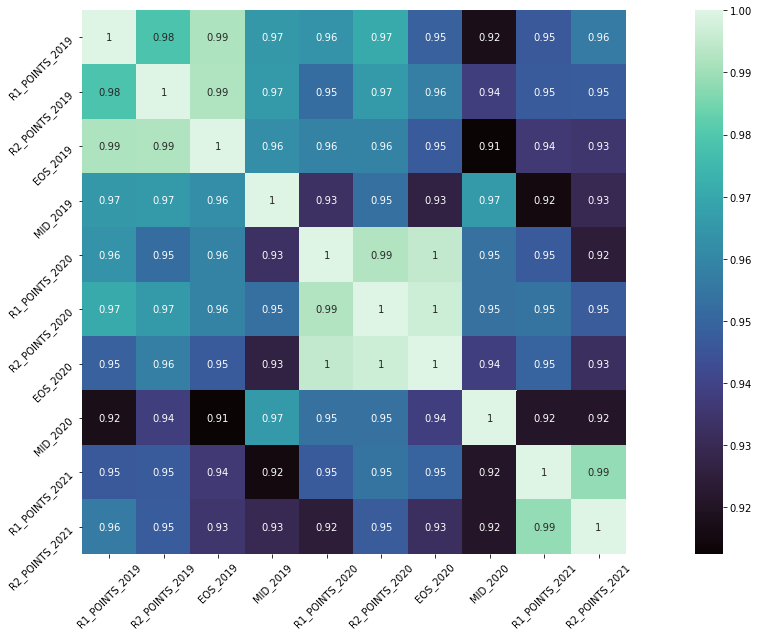

In [48]:
plt.rcParams['figure.figsize'] = [25, 10]
sns.heatmap (data = df_numeric.corr(), square = True, annot = True, cmap = "mako")
plt.xticks (rotation = 45)
plt.yticks (rotation = 45)
plt.show()

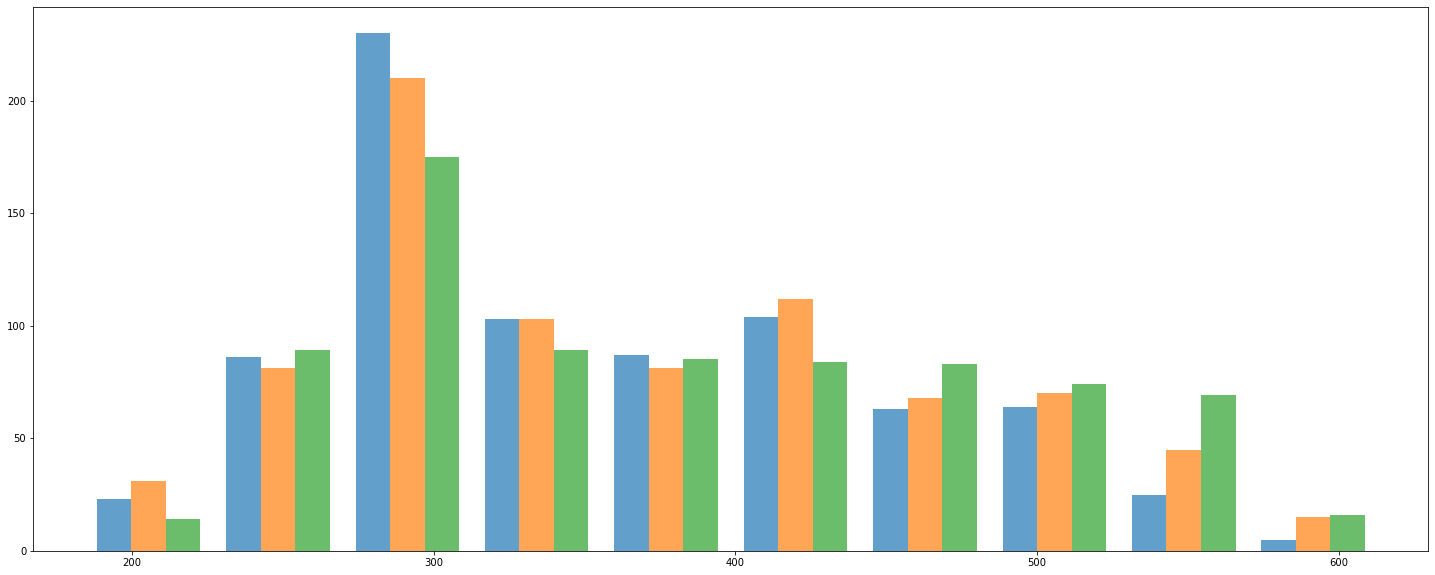

In [37]:
plt.xticks (ticks = (100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100))
plt.hist ([r1_2019, r1_2020, r1_2021], alpha = 0.7)
plt.show()

In [38]:
new = pd.read_csv ("Numeric_table.csv")
c = new [["MID_2019", "MID_2020"]]

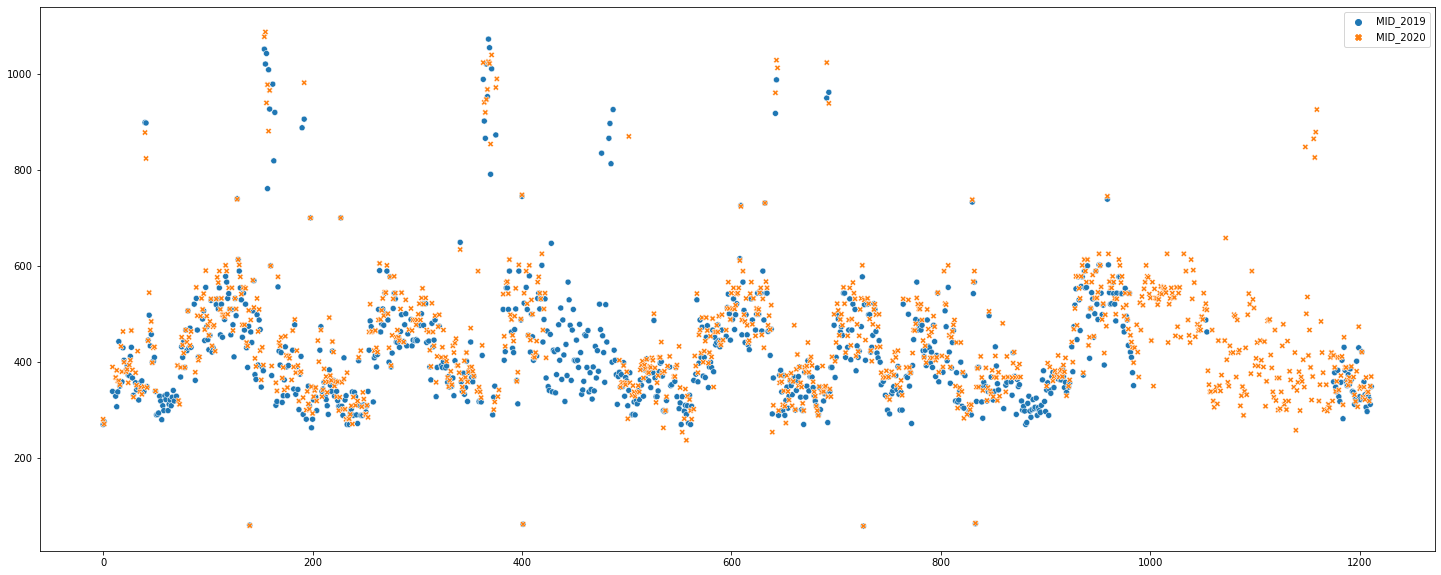

In [39]:
sns.scatterplot (data = c)
plt.show()

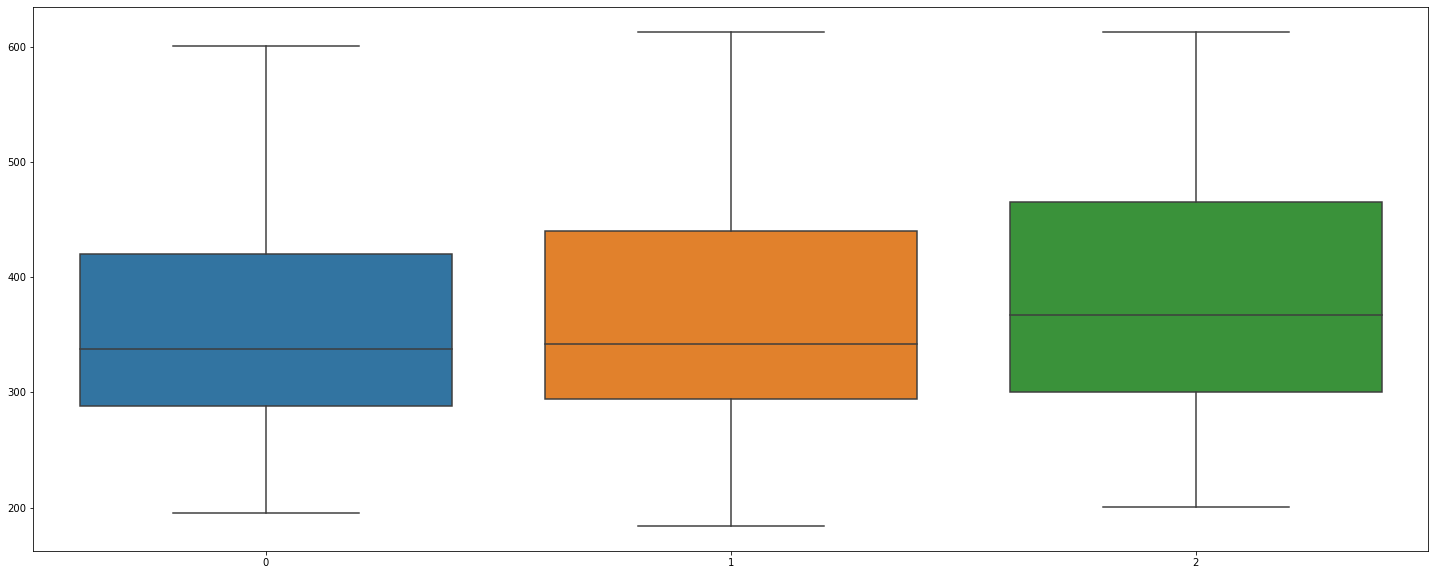

In [40]:
sns.boxplot (data = [r1_2019, r1_2020, r1_2021])
plt.show()

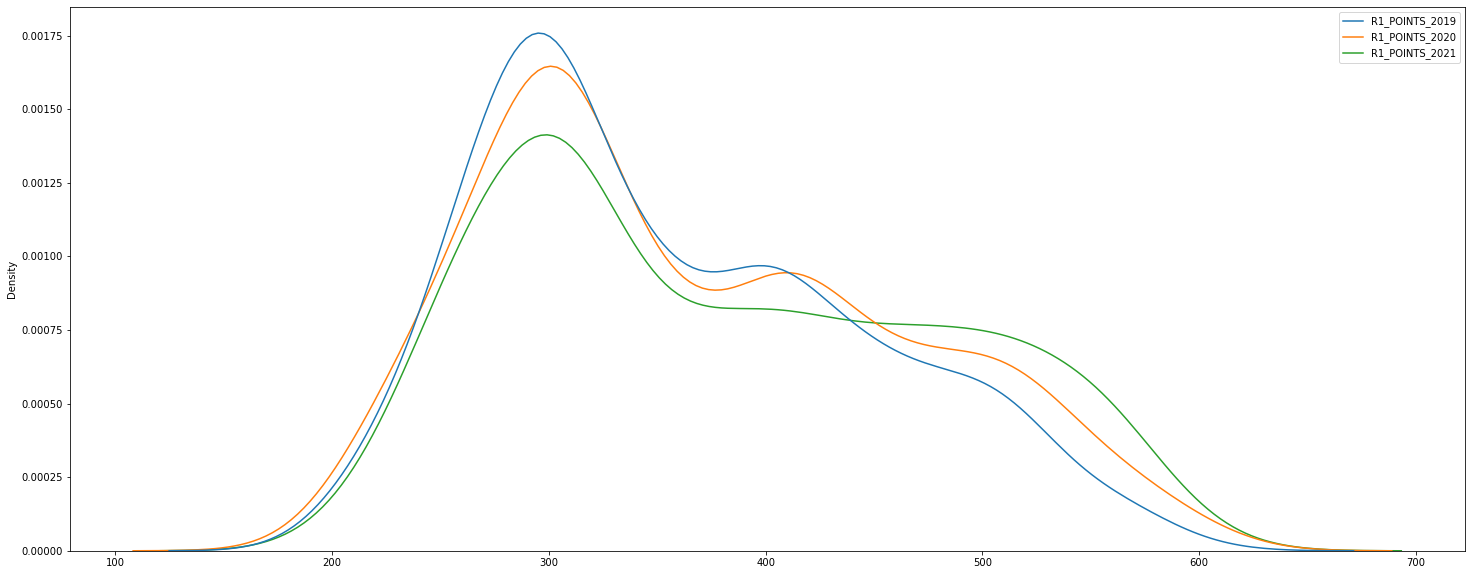

In [41]:
sns.kdeplot (data = [r1_2019, r1_2020, r1_2021])
plt.show()

### DATA COMPARISON

# CONCLUSION

***

## REFERENCES
***

- [1] http://www2.cao.ie/handbook/handbook2022/hb.pdf
- [2] https://en.wikipedia.org/wiki/Central_Applications_Office7
- [3] https://www.independent.ie/life/family/learning/understanding-your-cao-course-guide-26505318.html
- [4] https://en.wikipedia.org/wiki/Regular_expression

## TESTING

In [42]:
df_numeric.dropna(axis = 0, how = 'all', inplace = True)
df_numeric

,,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
CODE,TITLE,,,,,,,,,,
AC120,International Business,234.0,234.0,234.0,269.0,209.0,NaN,209.0,280.0,294.0,294.0
AC137,Liberal Arts,275.0,252.0,252.0,275.0,252.0,NaN,252.0,270.0,271.0,270.0
AD215,Visual Culture,300.0,NaN,300.0,338.0,377.0,320.0,320.0,389.0,337.0,300.0
AL801,Software Design with Virtual Reality and Gaming,304.0,NaN,304.0,328.0,303.0,NaN,303.0,367.0,300.0,NaN
AL802,Software Design with Cloud Computing,301.0,NaN,301.0,306.0,332.0,NaN,332.0,382.0,313.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
WD211,Creative Computing,275.0,NaN,275.0,322.0,271.0,NaN,271.0,318.0,270.0,NaN
WD212,Recreation and Sport Management,274.0,NaN,274.0,311.0,270.0,NaN,270.0,349.0,262.0,NaN
WD230,Mechanical and Manufacturing Engineering,273.0,NaN,273.0,348.0,253.0,NaN,253.0,369.0,230.0,230.0


In [43]:
df2019_num_r1 = df ["R1_POINTS_2019"]
df2019_num_r2 = df_numeric ["R2_POINTS_2019"]
df2019_num_eos = df_numeric ["EOS_2019"]
df2019_num_mid = df_numeric ["MID_2019"]

df2020_num_r1 = df_numeric ["R1_POINTS_2020"]
df2020_num_r2 = df_numeric ["R2_POINTS_2020"]
df2020_num_eos = df_numeric ["EOS_2020"]
df2020_num_mid = df_numeric ["MID_2020"]

df2021_num_r1 = df_numeric ["R1_POINTS_2021"]
df2021_num_r2 = df_numeric ["R2_POINTS_2021"]

In [44]:
df2019_num_r1

CODE   TITLE                                             
AC120  International Business                                     234
AC137  Liberal Arts                                               275
AD101  First Year Art & Design (Common Entry)                #+Matric
AD102  Graphic Design and Moving Image Design                #+Matric
AD103  Textile & Surface Design and Jewellery & Objects      #+Matric
                                                               ...   
WD211  Creative Computing                                         275
WD212  Recreation and Sport Management                            274
WD230  Mechanical and Manufacturing Engineering                   273
WD231  Early Childhood Care and Education                         NaN
WD232  Business Information Systems                               NaN
Name: R1_POINTS_2019, Length: 1214, dtype: object

In [45]:
a = df2019_num_r1[df2019_num_r1.str.contains("\*", na = False)]
a

CODE   TITLE                                             
AL832  Psychiatric Nursing                                    387*
AS002  Education Home Economics and Religious Ed - with c     401*
CK201  Commerce                                               465*
CK710  General Nursing                                        444*
CK712  Children`s and General Nursing (Integrated)            509*
DC002  Education - Primary Teaching                           462*
DC171  Applied Physics                                        402*
DC173  Physics with Biomedical Sciences                       402*
DC218  Children`s and General Nursing (Integrated)            473*
DK877  Midwifery                                              398*
DN230  Actuarial and Financial Studies                        577*
DN401  Medicine - Graduate Entry (GAMSAT required)            #59*
DN650  Commerce                                               498*
GY501  Medicine (five year/six year course HPAT required)    #726*
LM09

In [46]:
b = a['R1_POINTS_2019'].str.split('[0-9]').str[-1]
b

KeyError: 'R1_POINTS_2019'

In [ ]:
b.count()

| SYMBOL | MEANING |
| :-: | :- |
| * | Not all on this points score were offered places |
| # | Test / Interview / Portfolio / Audition |
| AQA | All qualified applicants |
| v | New competition for available places |